# Optimal period grid and optimal duration grid for transit searches

This tutorial explains the optimal period and duration grid, as implemented by the Transit Least Squares algorithm and explained in detail in our paper [(Hippke & Heller 2019)](https://arxiv.org/abs/1901.02015).

For transit searches with the Box Least Squares (BLS, [Kovács+ 2002](http://adsabs.harvard.edu/abs/2002A%26A...391..369K)) algorithm, the most commonly used grid is linear in duration and period, and searches the grid space fully. Roughly, individual searches can be visualized in the 2D plane of period and duration:

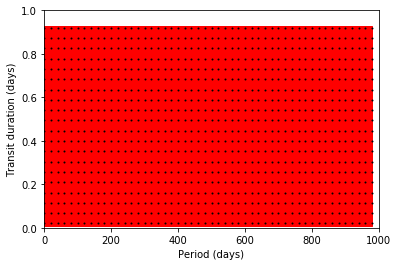

In [6]:
import numpy
import matplotlib.pyplot as plt
import matplotlib.patches as patches
ax = plt.gca()
rect = patches.Rectangle((0.5, 0.01), 980, 0.92, linewidth=1, edgecolor='r', facecolor='red')
ax.add_patch(rect)
for x in numpy.linspace(0.5, 980, 50):
    for y in numpy.linspace(0.02, 0.92, 20):
        plt.plot(x, y, color='black', marker='o', markersize=1)
ax.set_xlabel(r'Period (days)')
ax.set_ylabel(r'Transit duration (days)')
ax.set_xlim(0, 1000)
ax.set_ylim(0, 1);

## Period grid
This filled linear period-duration grid is simple, but it has a major disadvantage. For a reasonable sensitivity over all trial periods, short periods require a much denser sampling compared to long periods. As an example, thousands of periods need to be sampled for $0.5<P<1$ day. Periods between 365 and 366 days, however, require only a few trials to achieve similar sensitivity. A linear grid which is sufficiently dense for
short periods will thus be computationally inefficient at longer periods.

[Ofir (2014)](https://ui.adsabs.harvard.edu/#abs/2014A&A...561A.138O/abstract) derived the optimal number of test frequencies as

\begin{equation}
N_{\rm freq,,opt} = \left( f_{\rm max}^{1/3} - f_{\rm min}^{1/3} + \frac{A}{3} \right) \frac{3}{A}
\end{equation}

with

\begin{equation}
A=
\frac{(2\pi)^{2/3}}{\pi }
\frac{R_{\rm s}}{(GM_{\rm s})^{1/3}}
\frac{1}{S \times OS} \ ,
\end{equation}

where $G$ is the gravitational constant, $S$ is the time span of the data set, and $OS$ is the oversampling parameter to be chosen between 2 and 5 to ensure that the SDE peak is not missed between trial frequencies (or periods). The minimum and maximum trial orbital frequencies can be found at $f_{\rm min}=2/S$ (or $f_{\rm min}=3/S$ if three transits are required) and at the most short-period (high-frequency) circumstellar orbit, the Roche limit, $f_{\rm max}= \sqrt{GM_{\rm s}/(3R_{\rm s})^3} / (2\pi)$. Strictly speaking, the Roche limit depends on the density ($\rho_{\rm p}$) of the planet, and the term $3{\,}R_{\rm s}$ for our expression of $f_{\rm max}$ assumes the most pessimistic case of an extremely low-density fluid-like planet with $\rho_{\rm p} \sim 1{\,}{\rm g{\,}cm}^{-3}$, which can be compared to Jupiter's mean density of $1.33{\,} {\rm g{\,}cm}^{-3}$. Our TLS implementation generates an array of evenly spaced orbital frequencies with $N_{\rm freq,opt}$ constant steps between $f_{\rm min}$ and $f_{\rm max}$ and then computes the (non-uniform) trial orbital periods as the inverse of this frequency grid.

Since computational speed is a key concern for TLS, we illustrate the resulting number of trial periods in the following Figure, using three different time spans $S$ of a hypothetical light curve for different stellar masses (and radii, assuming main-sequence mass-radius relation).

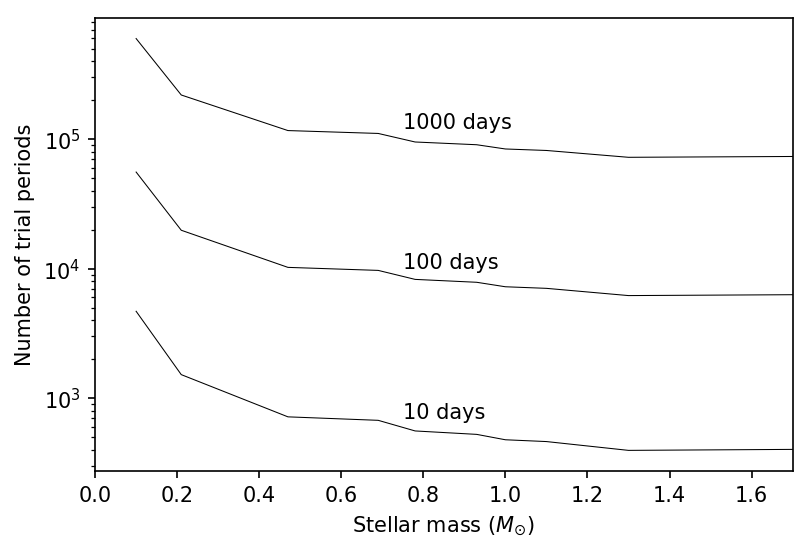

In [25]:
from transitleastsquares import period_grid
from matplotlib import rcParams; rcParams["figure.dpi"] = 150
import numpy
import matplotlib.pyplot as plt

# Main sequence stars with masses and radii
R = numpy.array([0.13, 0.32, 0.63, 0.74, 0.85, 0.93, 1, 1.05, 1.2, 1.3])
M = numpy.array([0.1,  0.21, 0.47, 0.69, 0.78, 0.93, 1, 1.1,  1.3, 1.7])

p10d = []
p100d = []
p1000d = []
for i in range(len(R)):
    p10d.append(len(period_grid(R[i], M[i], 10)))
    p100d.append(len(period_grid(R[i], M[i], 100)))
    p1000d.append(len(period_grid(R[i], M[i], 1000)))
plt.plot(M, p10d, color='black', lw=0.5)
plt.plot(M, p100d, color='black', lw=0.5)
plt.plot(M, p1000d, color='black', lw=0.5)

plt.text(0.75, 1.2*10**5, '1000 days')
plt.text(0.75, 10**4, '100 days')
plt.text(0.75, 0.7*10**3, '10 days')

plt.yscale('log')
plt.xlim(0, 1.7)
plt.ylabel(r'Number of trial periods')
plt.xlabel(r'Stellar mass ($M_{\odot}$)');

We find that an extension of the light curve by a certain factor -- here ten between the three example curves -- increases the number of trial periods by the same factor. This plot warns us of the large number of trial periods that need to be examined for planets around low-mass stars, with $N_{\rm freq, opt}$ reaching values of up to almost one million for a light curve with 1000 d of continuous observations of a very-low-mass star. This feature is inherent to both TLS and BLS.

## Duration grid
Regarding the transit duration, we now show that a linear grid is not optimal.

Transit searches using the BLS algorithm usually operate with trial transit
durations $T_{14}$ that span
$0.00125-0.07\times$ [(Petigura+ 2013)](https://ui.adsabs.harvard.edu/#abs/2013ApJ...770...69P/abstract), $0.01-0.1\times$ [Giacobbe 2012+](https://ui.adsabs.harvard.edu/#abs/2012MNRAS.424.3101G/abstract), or $0.001-0.2\times$ [(Sanchis-Ojeda 2014+](https://ui.adsabs.harvard.edu/#abs/2014ApJ...787...47S/abstract), [Aigrain 2016+)](https://ui.adsabs.harvard.edu/#abs/2016MNRAS.459.2408A/abstract) the orbital period.

For circular orbits, the maximum transit duration is $T_{14,{\rm max}}~=~2(R_{\rm s}+R_{\rm p})/v_{\rm p}$, where $v_{\rm p}$ is the planet's average orbital velocity during the transit. Shorter transit durations are possible if the planetary transit path is not across the stellar diameter. We then have

\begin{equation}
T_{14,{\rm max}} = \frac{2,(R_{\rm s}+R_{\rm p})}{v_{\rm p}} = \frac{2,(R_{\rm s}+R_{\rm p})}{2\pi a / P}
\end{equation}

In the limit of the star being much more massive than the planet, Kepler's third law becomes

\begin{align}
\left(\frac{2\pi}{P}\right)^2 \ a^3 \approx \ & G M_{\rm s} \
\Leftrightarrow \hspace{1.8cm} a \approx \ & \left( G M_{\rm s} \left( \frac{P}{2\pi} \right)^2 \right)^{1/3} \ .
\end{align}

We insert the second into the first Equation and obtain

\begin{align}
T_{14,{\rm max}} = \ & \frac{(R_{\rm s}+R_{\rm p}) , P}{\pi} \left( \frac{1}{G M_{\rm s}} \left( \frac{2\pi}{P} \right)^2 \right)^{1/3} \
= \ & (R_{\rm s}+R_{\rm p}) \left( \frac{4P}{\pi G M_{\rm s}} \right)^{1/3} \ .
\end{align}

We now plot this equation for $R_{\rm p}=2,R_{\rm J}$ ($R_{\rm J}$ being Jupiter's radius) orbiting an A5 star ($M_{\rm s}=2.1,M_\odot, R_{\rm s}=1.7,R_\odot$) to maximize the effect of a very large planet on the transit duration. To embrace the physically plausible search space, we also show a main-sequence M8 red dwarf star ($M_{\rm s}=0.1{\,}M_\odot,{\,} R_{\rm s}=0.13{\,}R_\odot$) and a sun-like star, both with a small planet ($R_{\rm p}={\,}R_{\rm \oplus}$).

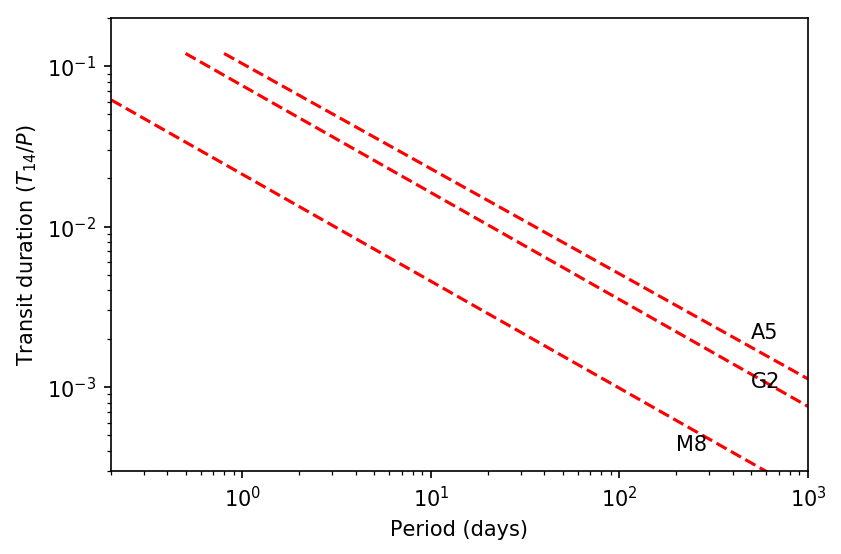

In [29]:
from numpy import pi

# astrophysical constants
SECONDS_PER_DAY = 86400
G = 6.67408e-11  # gravitational constant [m^3 / kg / s^2]
R_sun = 695508000  # radius of the Sun [m]
R_jup = 69911000  # radius of Jupiter [m]
M_sun = 1.989 * 10 ** 30  # mass of the Sun [kg]

# Maximum fractional transit duration ever observed is 0.117
# for Kepler-1368 b (as of Oct 2018), so we set upper_limit=0.12
# Long fractional transit durations are computationally expensive
# following a quadratic relation. If applicable, use a different value.
# Longer transits can still be found, but at decreasing sensitivity
FRACTIONAL_TRANSIT_DURATION_MAX = 0.12


def T14(R_s, M_s, P, upper_limit=FRACTIONAL_TRANSIT_DURATION_MAX, small_planet=False):
    """Input:  Stellar radius and mass [in solar units]; planetary period [in days]
       Output: Maximum planetary transit duration T_14max [in fraction of period P]"""

    P = P * SECONDS_PER_DAY
    R_s = R_sun * R_s
    M_s = M_sun * M_s

    if small_planet:  # small planet assumption: planet size negligible
        T14 = R_s * ((4 * P) / (pi * G * M_s)) ** (1 / 3)
    else:  # planet size 2 R_jup
        T14 = (R_s + 2 * R_jup) * ((4 * P) / (pi * G * M_s)) ** (1 / 3)

    result = T14 / P

    # Assert all return values (float or in array) are <= upper_limit
    if type(result) is float:
        result = min(result, upper_limit)
    else:
        result[result > upper_limit] = upper_limit
    return result


def make_plot():
    # M8, G2, A5
    periods = numpy.geomspace(0.8, 1000, 2)
    plt.plot(periods, T14(R_s=1.7, M_s=2.1, P=periods), linestyle='dashed', color='red')
    periods = numpy.geomspace(0.5, 1000, 2)
    plt.plot(periods, T14(R_s=1, M_s=1, P=periods, small_planet=True), linestyle='dashed', color='red')
    periods = numpy.geomspace(0.1, 1000, 2)
    plt.plot(periods, T14(R_s=0.13, M_s=0.1, P=periods, small_planet=True), linestyle='dashed', color='red')

    plt.text(200, 0.0004, 'M8')
    plt.text(500, 0.001, 'G2')
    plt.text(500, 0.002, 'A5')

    plt.xlabel(r'Period (days)')
    plt.ylabel(r'Transit duration ($T_{\rm 14}/P$)')
    plt.xscale('log')
    plt.yscale('log')
    plt.xlim(0.2, 1000)
    plt.ylim(0.0003, 0.2)

make_plot();

We now add to the plot all known transiting exoplanets:

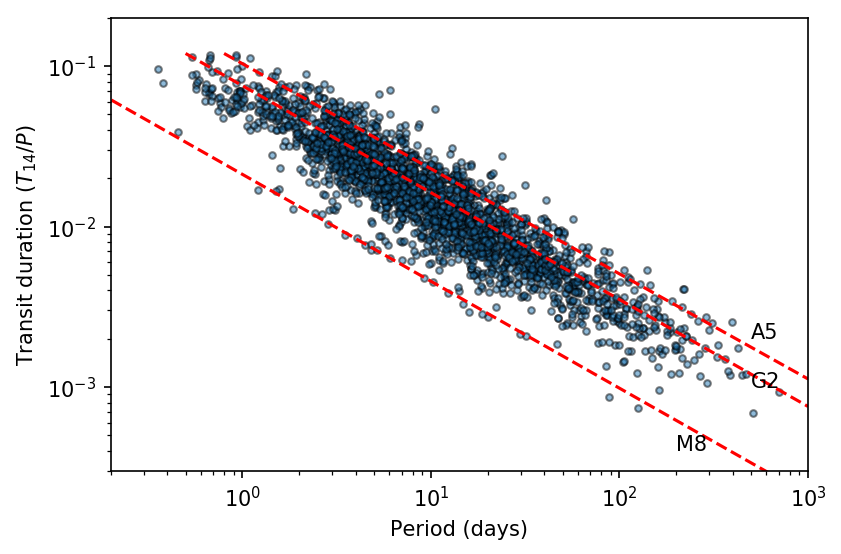

In [32]:
make_plot()
def add_data():
    data = numpy.genfromtxt(
        'data_per_t14.csv',
        dtype='f8, f8',
        names = ['period', 't14'])
    plt.scatter(data['period'], data['t14'], s=10, alpha=0.5, edgecolor='black');
add_data()

We see that a significant amount of planets is actually located above the uppermost 
of these lines, which can be attributed to bloated super-Jovian planets and/or to planets 
transiting slightly evolved stars, for example. The absence of planets in the lower 
left part of the diagram could be partly astrophysical in nature and interpreted as a 
trace of planet formation and evolution (e.g. the absence of ultra-short period planets 
around M dwarfs). That said, planets can naturally have transit durations that are 
arbitrarily shorter than $T_{14,\rm{max}}$, e.g. on eccentric or inclined orbits. 
The empty space can nevertheless be explained with a detection bias against planets 
with transit durations of just a few minutes, e.g. $\sim{\,}15{\,}$min for $P=1{\,}$d and 
$T_{14}/P=10^{-2}$.

In order to compensate for planets transiting evolved stars as well as for planets on 
eccentric orbits (in eccentric cases the average orbital velocity in-transit 
can be smaller or larger and the resulting transit duration can be larger or smaller 
than in the circular case.) and other astrophysical effects that are potentially hard 
to predict, we use the Figure to derive empirical estimates for the maximum 
and minimum values of $d$ to be searched. We parameterize the upper limit via 
the previous Equation and using $M_{\rm s}=1{\,}M_\odot$ and $R_{\rm s}=3.5{\,}R_\odot$, 
and we parameterize the lower limit of $T_{14}$ using $M_{\rm s}=1{\,}M_\odot$ and 
$R_{\rm s}=0.184\,R_\odot$. Note that these two parameterizations 
do not correspond to any particular or even physically plausible star. The motivation 
behind this parameterization is entirely empirical with the 
aim of embracing all known transiting exoplanets.

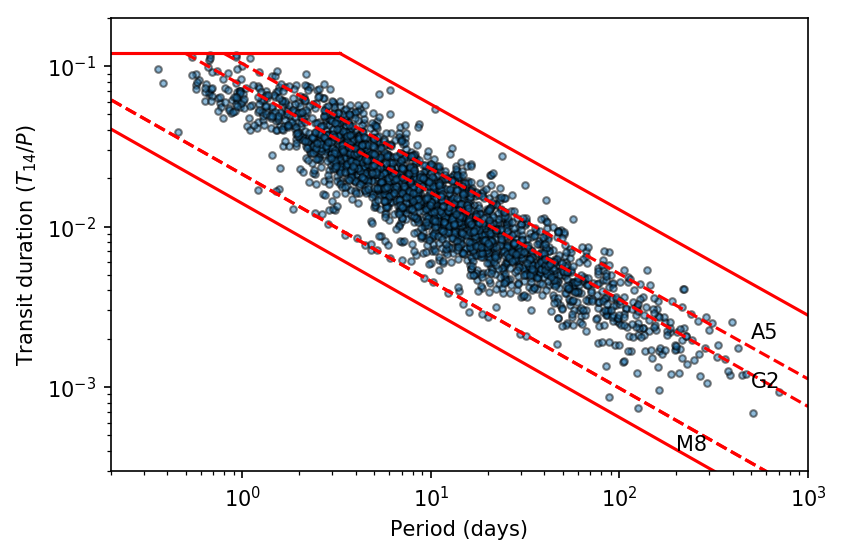

In [35]:
make_plot()
add_data()

# Upper limits
periods = numpy.geomspace(3.3, 1000, 2)
plt.plot(periods, T14(R_s=3.5, M_s=1, P=periods), color='red')
plt.plot((0.01, 3.3), (0.12, 0.12), color='red')

# Bottom border
periods = numpy.geomspace(0.1, 1000, 2)
plt.plot(periods, T14(R_s=0.184, M_s=1, P=periods, small_planet=True), color='red')
plt.plot(periods, T14(R_s=0.13, M_s=0.1, P=periods, small_planet=True), linestyle='dashed', color='red');

These empirical limits for the transit durations to be searched with TLS are 
shown with inclined solid lines and their parameterization 
was intentionally chosen to encompass all known transiting exoplanets. The horizontal 
cutoff at $T_{14}/P \sim~0.12$ is a global threshold. This is the default 
region in the $T_{14}$-$(P)$ diagram to be tested with our implementation of the TLS
algorithm. That said, the user can define their own range of transit durations to be tested.